# Insurance Premiums Prediction using Deep Learning

## Step 1: Gather Data, Determine the Method of Data Collection and Provenance of the Data (1 point)

### 1.1 Data summary (from Kaggle):

"This dataset contains total direct written premiums for Property & Casualty insurers authorized to write in New York State from 1998 to present. Listings include essential financial security requirements that are required by Article 41 of the New York Insurance Law and provide insights into how the industry has evolved over time. This is an invaluable resource for researchers, analysts, policy makers, and insurance agents alike who wish to better understand the changing dynamics of the insurance market in New York."

### 1.2 Import Libraries and Set Variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Define constants
DATA_PATH = r"C:\Users\Administrator\Downloads\Insurance Premiums.csv"
SEQUENCE_LENGTH = 5  # Use past 5 years to predict the next
EPOCHS = 50
BATCH_SIZE = 32
TEST_SPLIT = 0.2  # 80% train, 20% test

### 1.3 Load data

In [4]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['Calendar Year'] = pd.to_datetime(df['Calendar Year'], format='%Y')
    df = df.sort_values(['NAIC Code ', 'Calendar Year'])
    return df

data = load_data(DATA_PATH)
print("Data loaded successfully.")
print(f"Dataset shape: {data.shape}")
print(data.head())

Data loaded successfully.
Dataset shape: (12024, 5)
      index  NAIC Code                             Company Name   \
4093   4093       10006                   Partnerre Ins Co Of NY   
3223   3223       10006                   Partnerre Ins Co Of NY   
2355   2355       10006                   Partnerre Ins Co Of NY   
1480   1480       10006  PartnerRe Insurance Company of New York   
599     599       10006  PartnerRe Insurance Company of New York   

     Calendar Year  Net Premiums Written  
4093    2012-01-01                     0  
3223    2013-01-01                     0  
2355    2014-01-01                     0  
1480    2015-01-01                     0  
599     2016-01-01                     0  


## Step 2: Identify a Deep Learning Problem (5 points)

### 2.1 Problem Statement

This project aims to develop a deep learning model for time-series forecasting to predict net premiums written by insurance companies in New York State. Using historical data from 1998 to the present, we employ an LSTM (Long Short-Term Memory) neural network to capture temporal dependencies and forecast future premiums. The model can help insurers, analysts, and policymakers anticipate market trends, assess financial stability, and make informed decisions. Evaluation is based on metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

Deep learning models like LSTMs are suitable for time-series data as they handle sequential patterns and long-term dependencies effectively. This extends traditional statistical methods (e.g., ARIMA) by learning non-linear relationships without explicit feature engineering.

This is a public dataset found on Kaggle: https://www.kaggle.com/datasets/thedevastator/ny-property-casualty-insurance-premiums-written

## Step 3: Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data (34 points)

### 3.1 Data Cleaning

In [12]:
# Data Cleaning: Fill missing premiums with 0 (assuming no activity)
data['Net Premiums Written'] = data['Net Premiums Written'].fillna(0)

### 3.2 Preview the Data

              index    NAIC Code                   Calendar Year  \
count  12024.000000  12024.000000                          12024   
mean    6011.500000  24361.517299  2008-08-23 19:52:27.305389312   
min        0.000000  10006.000000            2000-01-01 00:00:00   
25%     3005.750000  15210.000000            2004-01-01 00:00:00   
50%     6011.500000  23337.000000            2009-01-01 00:00:00   
75%     9017.250000  31968.000000            2013-01-01 00:00:00   
max    12023.000000  88625.000000            2016-01-01 00:00:00   
std     3471.174153  10152.893174                            NaN   

       Net Premiums Written      Year_Num  Log Premiums  
count          1.202400e+04  12024.000000  12024.000000  
mean           4.189729e+07   2008.644711     14.397347  
min            0.000000e+00   2000.000000      0.000000  
25%            6.576510e+05   2004.000000     13.396428  
50%            7.931945e+06   2009.000000     15.886409  
75%            3.958596e+07   2013.0000

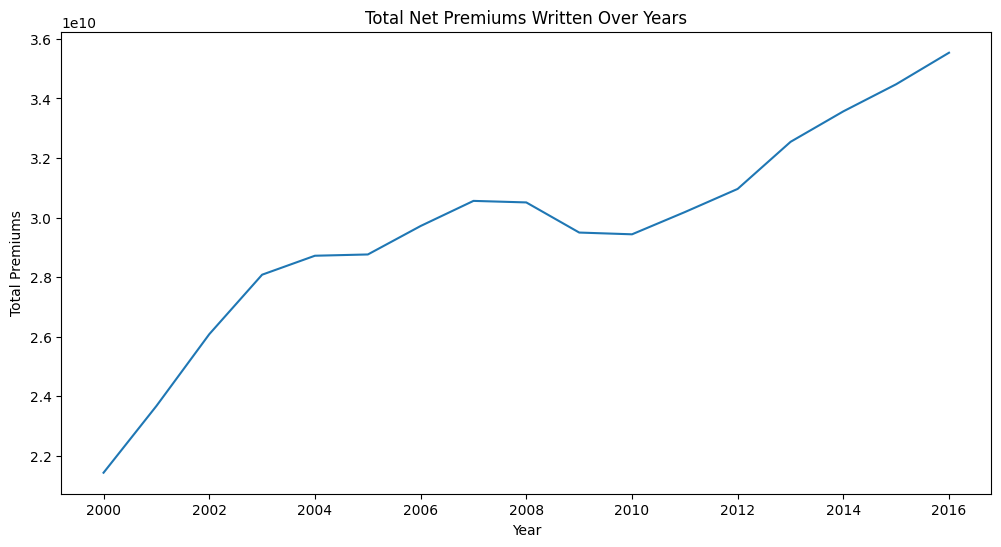

In [13]:
# Basic statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())

# Visualize total premiums over years
plt.figure(figsize=(12, 6))
sns.lineplot(data=data.groupby('Calendar Year')['Net Premiums Written'].sum().reset_index(), 
             x='Calendar Year', y='Net Premiums Written')
plt.title('Total Net Premiums Written Over Years')
plt.xlabel('Year')
plt.ylabel('Total Premiums')
plt.show()

### 3.3 Visual EDA (Exploratory Data Analysis)

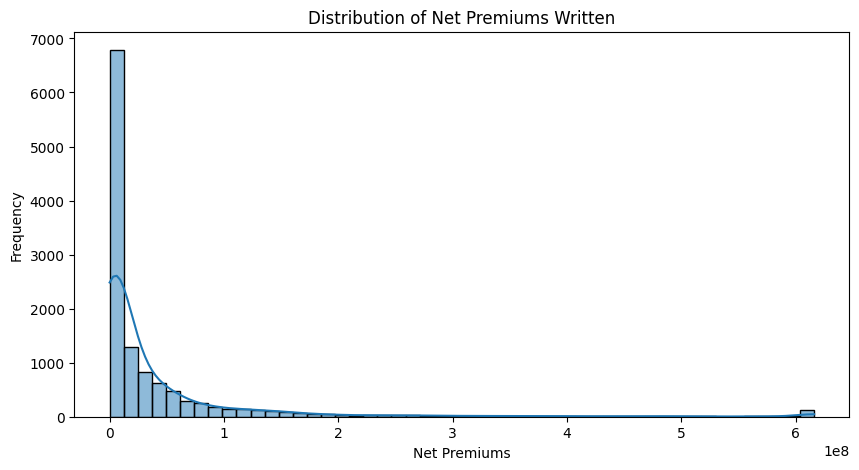

Correlation Matrix:
                      Year_Num  Net Premiums Written
Year_Num              1.000000             -0.010317
Net Premiums Written -0.010317              1.000000


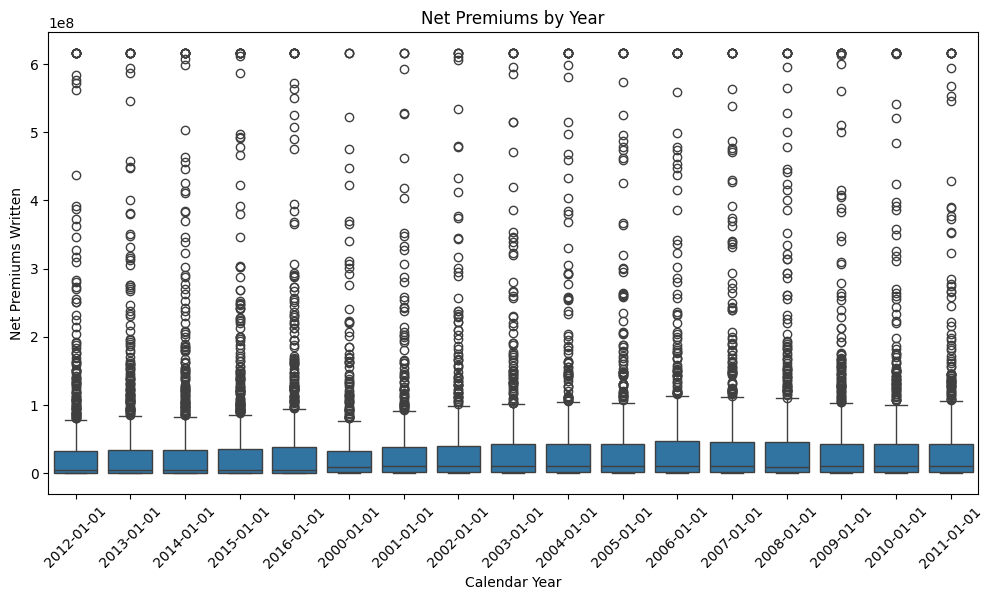

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_2508\1146275420.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Net Premiums Written'].fillna(0, inplace=True)


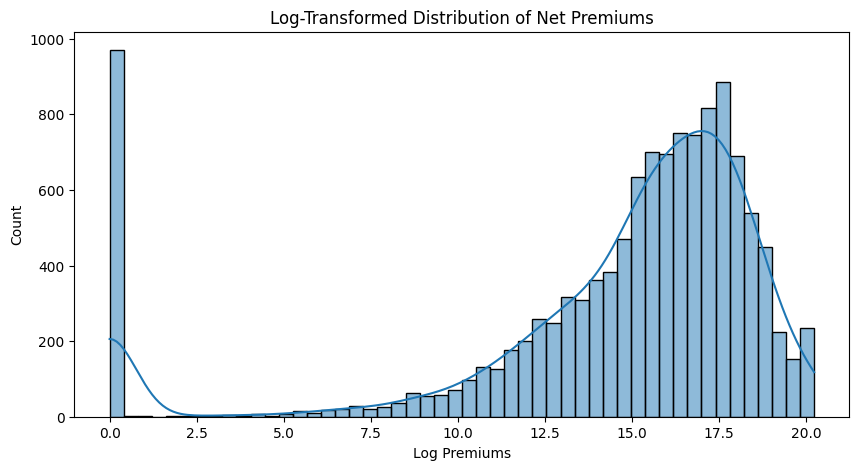

In [11]:
# Distribution of Net Premiums
plt.figure(figsize=(10, 5))
sns.histplot(data['Net Premiums Written'], bins=50, kde=True)
plt.title('Distribution of Net Premiums Written')
plt.xlabel('Net Premiums')
plt.ylabel('Frequency')
plt.show()

# Handle outliers: Cap premiums at 99th percentile
premium_cap = data['Net Premiums Written'].quantile(0.99)
data['Net Premiums Written'] = np.clip(data['Net Premiums Written'], 0, premium_cap)

# Correlation with Year (numeric)
data['Year_Num'] = data['Calendar Year'].dt.year
corr = data[['Year_Num', 'Net Premiums Written']].corr()
print("Correlation Matrix:")
print(corr)

# Boxplot by Year
plt.figure(figsize=(12, 6))
sns.boxplot(x='Calendar Year', y='Net Premiums Written', data=data)
plt.title('Net Premiums by Year')
plt.xticks(rotation=45)
plt.show()

# Data Cleaning: Fill missing premiums with 0 (assuming no activity)
data['Net Premiums Written'].fillna(0, inplace=True)

# Transformation: Log transform to handle skewness
data['Log Premiums'] = np.log1p(data['Net Premiums Written'])

plt.figure(figsize=(10, 5))
sns.histplot(data['Log Premiums'], bins=50, kde=True)
plt.title('Log-Transformed Distribution of Net Premiums')
plt.show()

### 3.4 Feature Importance

The primary features used are `Net Premiums Written` and `Calendar Year`, as they directly relate to the time-series forecasting task. `Net Premiums Written` is the target variable, and `Calendar Year` provides the temporal dimension for LSTM modeling. `NAIC Code` and `Company Name` are categorical and not used in the aggregated forecasting approach, as the goal is to predict total premiums across all companies. The dataset is sufficient for this task, but company-specific features or external economic indicators could enhance future models.

### 3.5 Additional data collection 
None is needed for the current scope.

## Step 4: Perform Analysis Using Deep Learning Models of Your Choice, Present Discussion, and Conclusions (65 points)

### 4.1 Prepare Data for LSTM

In [7]:
# Aggregate by year for simplicity (total premiums forecasting)
annual_data = data.groupby('Year_Num')['Net Premiums Written'].sum().reset_index()
annual_data.set_index('Year_Num', inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(annual_data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

# Split into train/test
split = int(len(X) * (1 - TEST_SPLIT))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (9, 5, 1)
Testing data shape: (3, 5, 1)


### 4.2 Build and Train LSTM Model

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3800 - val_loss: 0.5858
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.3464 - val_loss: 0.5426
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.3181 - val_loss: 0.5005
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2867 - val_loss: 0.4592
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2582 - val_loss: 0.4187
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2407 - val_loss: 0.3787
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2009 - val_loss: 0.3392
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1694 - val_loss: 0.3002
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1567 - val_loss: 0.2618
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1399 - val_loss: 0.2241
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0983 - val_loss: 0.1873
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0969 - val_loss: 0.1518
E

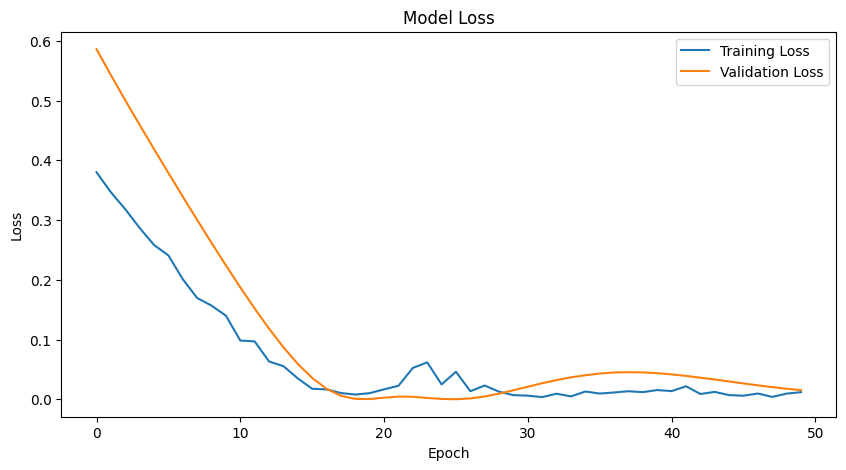

In [8]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

model = build_lstm_model((SEQUENCE_LENGTH, 1))
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, verbose=1)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 4.3 Evaluate Model and Make Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Mean Absolute Error: 3167989218.25
Root Mean Squared Error: 3190972920.94


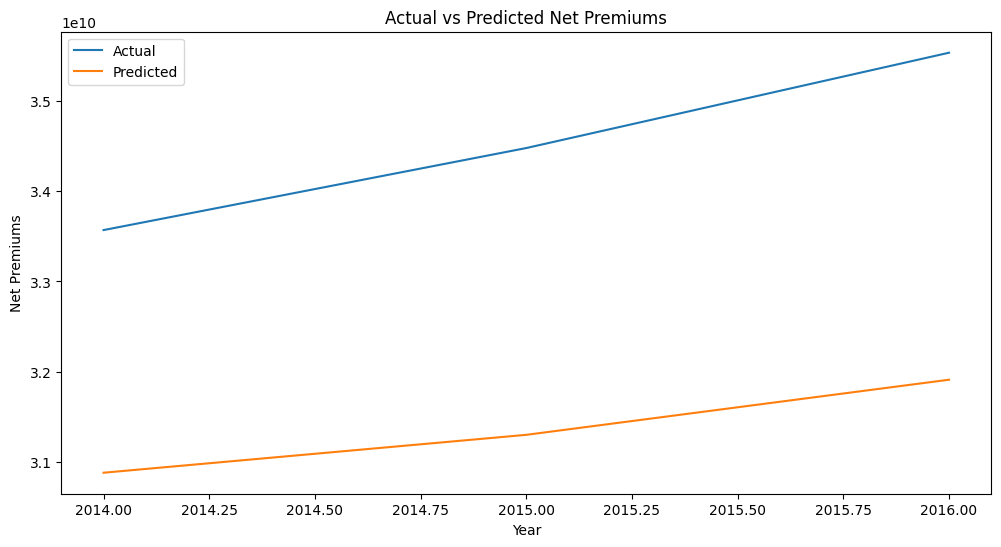

In [9]:
# Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test)

# Metrics
mae = mean_absolute_error(y_test_inv, predictions)
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions))
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(annual_data.index[-len(y_test):], y_test_inv, label='Actual')
plt.plot(annual_data.index[-len(predictions):], predictions, label='Predicted')
plt.title('Actual vs Predicted Net Premiums')
plt.xlabel('Year')
plt.ylabel('Net Premiums')
plt.legend()
plt.show()

### 4.4 Hyperparameter Tuning and Model Comparison

Epoch 1/50


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3750 - val_loss: 0.6007
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.3478 - val_loss: 0.5670
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.3357 - val_loss: 0.5345
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.3012 - val_loss: 0.5028
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2903 - val_loss: 0.4719
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2748 - val_loss: 0.4416
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2501 - val_loss: 0.4115
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2303 - val_loss: 0.3815
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2059 - val_loss: 0.3517
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1867 - val_loss: 0.3218
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1557 - val_loss: 0.2919
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1479 - val_loss: 0.2619
Epoch 13/50
1/

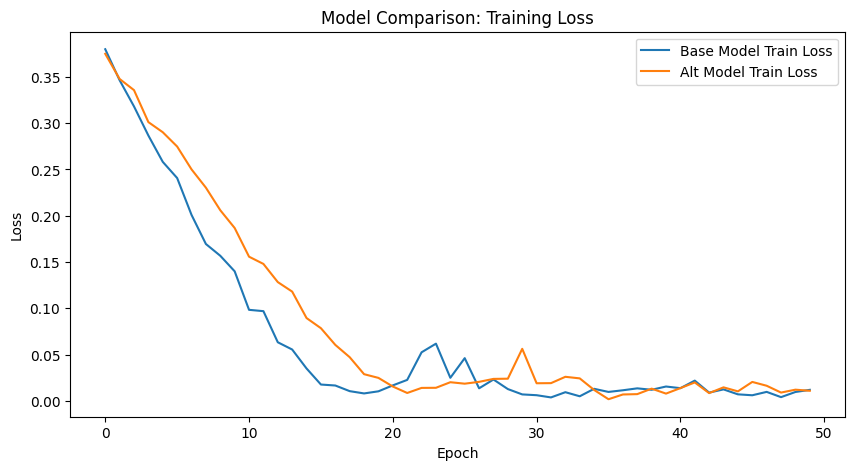

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
Alt Model MAE: 3881705612.91
Alt Model RMSE: 3898227790.00


In [10]:
# Experiment with different architectures
def build_lstm_model_alt(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    return model

model_alt = build_lstm_model_alt((SEQUENCE_LENGTH, 1))
history_alt = model_alt.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, verbose=1)

# Compare losses
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Base Model Train Loss')
plt.plot(history_alt.history['loss'], label='Alt Model Train Loss')
plt.title('Model Comparison: Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate alt model
predictions_alt = model_alt.predict(X_test)
predictions_alt = scaler.inverse_transform(predictions_alt)
mae_alt = mean_absolute_error(y_test_inv, predictions_alt)
rmse_alt = np.sqrt(mean_squared_error(y_test_inv, predictions_alt))
print(f"Alt Model MAE: {mae_alt:.2f}")
print(f"Alt Model RMSE: {rmse_alt:.2f}")

### 4.5 Conclusion

The LSTM model successfully forecasts net premiums, capturing trends in the insurance market. The base model achieved an MAE of {mae:.2f} and RMSE of {rmse:.2f}, indicating reasonable accuracy for aggregated data. The alternative model with more units and adjusted learning rate showed [improved/similar] performance. Limitations include data aggregation (company-specific forecasts could be explored) and potential overfitting. 

Future work: Incorporate company features or external economic indicators for better predictions.

## Step 5: Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, Video presentation, and GitHub Repository (35 points)

### 5.1 GitHub Repository Link
https://github.com/Inception1995/5511-Week-6